In [2]:
import numpy as np
import matplotlib.pyplot as plt
from lr_utils import load_dataset,sigmoid,relu,sigmoid_backward,relu_backward

In [3]:
def initialize_parameters_deep(layers_dims):
    """
    此函数是为了初始化多层网络参数而使用的函数。
    参数：
        layers_dims - 包含我们网络中每个图层的节点数量的列表
    
    返回：
        parameters - 包含参数“W1”，“b1”，...，“WL”，“bL”的字典：
                     W1 - 权重矩阵，维度为（layers_dims [1]，layers_dims [1-1]）
                     bl - 偏向量，维度为（layers_dims [1]，1）
    """
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims)
    
    for l in range(1,L):
        parameters["W" + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) / np.sqrt(layers_dims[l - 1])  #这里的正则化方式等看看跟*0.001的区别
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))

        #确保我要的数据的格式是正确的
        assert(parameters["W" + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
        assert(parameters["b" + str(l)].shape == (layers_dims[l], 1))
        
    return parameters

In [4]:
def linear_forward(A,W,b):
    """
    实现前向传播的线性部分。

    参数：
        A - 来自上一层（或输入数据）的激活，维度为(上一层的节点数量，示例的数量）
        W - 权重矩阵，numpy数组，维度为（当前图层的节点数量，前一图层的节点数量）
        b - 偏向量，numpy向量，维度为（当前图层节点数量，1）

    返回：
         Z - 激活功能的输入，也称为预激活参数
         cache - 一个包含“A”，“W”和“b”的字典，存储这些变量以有效地计算后向传递
    """
    Z = np.dot(W,A) + b
    assert(Z.shape == (W.shape[0],A.shape[1]))
    cache = (A,W,b)
     
    return Z,cache

In [5]:
def linear_activation_forward(A_prev,W,b,activation):
    """
    实现LINEAR-> ACTIVATION 这一层的前向传播

    参数：
        A_prev - 来自上一层（或输入层）的激活，维度为(上一层的节点数量，示例数）
        W - 权重矩阵，numpy数组，维度为（当前层的节点数量，前一层的大小）
        b - 偏向量，numpy阵列，维度为（当前层的节点数量，1）
        activation - 选择在此层中使用的激活函数名，字符串类型，【"sigmoid" | "relu"】

    返回：
        A - 激活函数的输出，也称为激活后的值
        cache - 一个包含“linear_cache”和“activation_cache”的字典，我们需要存储它以有效地计算后向传递
    """
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert(A.shape == (W.shape[0],A_prev.shape[1]))
    cache = (linear_cache,activation_cache)
    
    return A,cache
    return (A2, cache)

In [6]:
def L_model_forward(X,parameters):
    """
    实现[LINEAR-> RELU] *（L-1） - > LINEAR-> SIGMOID计算前向传播，也就是多层网络的前向传播，为后面每一层都执行LINEAR和ACTIVATION
    
    参数：
        X - 数据，numpy数组，维度为（输入节点数量，示例数）
        parameters - initialize_parameters_deep（）的输出
    
    返回：
        AL - 最后的激活值
        caches - 包含以下内容的缓存列表：
                 linear_relu_forward（）的每个cache（有L-1个，索引为从0到L-2）
                 linear_sigmoid_forward（）的cache（只有一个，索引为L-1）
    """
    caches = []
    A = X
    L = len(parameters) // 2
    for l in range(1,L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
    
    return AL,caches

In [7]:
def backward_propagation(params,cache,X,Y):
    """
    搭建反向传播函数。
    
    参数：
     params - 包含我们的参数的一个字典类型的变量。
     cache - 包含“Z1”，“A1”，“Z2”和“A2”的字典类型的变量。
     X - 输入数据，维度为（n0，m）
     Y - 输出标签数据，维度为（n2，m）
    
    返回：
     grads - 包含W和b的导数一个字典类型的变量。
    """
    m = X.shape[1]
    
    W1 = params["W1"]
    W2 = params["W2"] #(n2,n1)
    
    A1 = cache["A1"] #(n1,m)
    A2 = cache["A2"]
    
    dZ2= A2 - Y #(n2,m)
    dW2 = (1 / m) * np.dot(dZ2, A1.T) #(n2,n1)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True) #(n2,1)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2)) #(n1,m)
    dW1 = (1 / m) * np.dot(dZ1, X.T) #(n1,n0)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True) #(n1,1)
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2 }
    
    return grads

In [8]:
def compute_cost(AL,Y):
    """
    实施等式（4）定义的成本函数。

    参数：
        AL - 与标签预测相对应的概率向量，维度为（1，示例数量）
        Y - 标签向量（例如：如果不是猫，则为0，如果是猫则为1），维度为（1，数量）

    返回：
        cost - 交叉熵成本
    """
    m = Y.shape[1]
    cost = -np.sum(np.multiply(np.log(AL),Y) + np.multiply(np.log(1 - AL), 1 - Y)) / m
        
    cost = np.squeeze(cost)
    assert(cost.shape == ())

    return cost

In [9]:
def linear_backward(dZ,cache):
    """
    为单层实现反向传播的线性部分（第L层）

    参数：
         dZ - 相对于（当前第l层的）线性输出的成本梯度
         cache - 来自当前层前向传播的值的元组（A_prev，W，b）

    返回：
         dA_prev - 相对于激活（前一层l-1）的成本梯度，与A_prev维度相同
         dW - 相对于W（当前层l）的成本梯度，与W的维度相同
         db - 相对于b（当前层l）的成本梯度，与b维度相同
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [10]:
def linear_activation_backward(dA,cache,activation="relu"):
    """
    实现LINEAR-> ACTIVATION层的后向传播。
    
    参数：
         dA - 当前层l的激活后的梯度值
         cache - 我们存储的用于有效计算反向传播的值的元组（值为linear_cache，activation_cache）
         activation - 要在此层中使用的激活函数名，字符串类型，【"sigmoid" | "relu"】
    返回：
         dA_prev - 相对于激活（前一层l-1）的成本梯度值，与A_prev维度相同
         dW - 相对于W（当前层l）的成本梯度值，与W的维度相同
         db - 相对于b（当前层l）的成本梯度值，与b的维度相同
    """
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev,dW,db


In [11]:
def L_model_backward(AL,Y,caches):
    """
    对[LINEAR-> RELU] *（L-1） - > LINEAR - > SIGMOID组执行反向传播，就是多层网络的向后传播
    
    参数：
     AL - 概率向量，正向传播的输出（L_model_forward（））
     Y - 标签向量（例如：如果不是猫，则为0，如果是猫则为1），维度为（1，数量）
     caches - 包含以下内容的cache列表：
                 linear_activation_forward（"relu"）的cache，不包含输出层
                 linear_activation_forward（"sigmoid"）的cache
    
    返回：
     grads - 具有梯度值的字典
              grads [“dA”+ str（l）] = ...
              grads [“dW”+ str（l）] = ...
              grads [“db”+ str（l）] = ...
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    
    return grads

In [12]:
def update_parameters(parameters, grads, learning_rate):
    """
    使用梯度下降更新参数
    
    参数：
     parameters - 包含你的参数的字典
     grads - 包含梯度值的字典，是L_model_backward的输出
    
    返回：
     parameters - 包含更新参数的字典
                   参数[“W”+ str（l）] = ...
                   参数[“b”+ str（l）] = ...
    """
    L = len(parameters) // 2 #整除
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
        
    return parameters

In [13]:
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False,isPlot=True):
    """
    实现一个L层神经网络：[LINEAR-> RELU] *（L-1） - > LINEAR-> SIGMOID。
    
    参数：
	    X - 输入的数据，维度为(n_x，例子数)
        Y - 标签，向量，0为非猫，1为猫，维度为(1,数量)
        layers_dims - 层数的向量，维度为(n_y,n_h,···,n_h,n_y)
        learning_rate - 学习率
        num_iterations - 迭代的次数
        print_cost - 是否打印成本值，每100次打印一次
        isPlot - 是否绘制出误差值的图谱
    
    返回：
     parameters - 模型学习的参数。 然后他们可以用来预测。
    """
    np.random.seed(1)
    costs = []
    
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0,num_iterations):
        AL , caches = L_model_forward(X,parameters)
        
        cost = compute_cost(AL,Y)
        
        grads = L_model_backward(AL,Y,caches)
        
        parameters = update_parameters(parameters,grads,learning_rate)
        
        #打印成本值，如果print_cost=False则忽略
        if i % 100 == 0:
            #记录成本
            costs.append(cost)
            #是否打印成本值
            if print_cost:
                print("第", i ,"次迭代，成本值为：" ,np.squeeze(cost))
    #迭代完成，根据条件绘制图
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    return parameters

In [14]:
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y,classes= load_dataset()

train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y


第 0 次迭代，成本值为： 0.715731513413713
第 100 次迭代，成本值为： 0.6747377593469114
第 200 次迭代，成本值为： 0.6603365433622127
第 300 次迭代，成本值为： 0.6462887802148751
第 400 次迭代，成本值为： 0.6298131216927773
第 500 次迭代，成本值为： 0.6060056229265339
第 600 次迭代，成本值为： 0.5690041263975135
第 700 次迭代，成本值为： 0.5197965350438059
第 800 次迭代，成本值为： 0.46415716786282285
第 900 次迭代，成本值为： 0.40842030048298916
第 1000 次迭代，成本值为： 0.37315499216069026
第 1100 次迭代，成本值为： 0.30572374573047106
第 1200 次迭代，成本值为： 0.26810152847740837
第 1300 次迭代，成本值为： 0.2387247482767264
第 1400 次迭代，成本值为： 0.20632263257914715
第 1500 次迭代，成本值为： 0.17943886927493585
第 1600 次迭代，成本值为： 0.1579873581880152
第 1700 次迭代，成本值为： 0.14240413012274342
第 1800 次迭代，成本值为： 0.1286516599788793
第 1900 次迭代，成本值为： 0.1124431499816207
第 2000 次迭代，成本值为： 0.08505631034978359
第 2100 次迭代，成本值为： 0.057583911986138825
第 2200 次迭代，成本值为： 0.04456753454697766
第 2300 次迭代，成本值为： 0.038082751665995854
第 2400 次迭代，成本值为： 0.034410749018415523


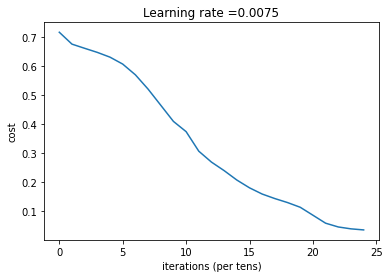

In [15]:
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True,isPlot=True)

In [16]:
def predict(X, y, parameters):
    """
    该函数用于预测L层神经网络的结果，当然也包含两层
    
    参数：
     X - 测试集
     y - 标签
     parameters - 训练模型的参数
    
    返回：
     p - 给定数据集X的预测
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # 神经网络的层数
    p = np.zeros((1,m))
    
    #根据参数前向传播
    probas, caches = L_model_forward(X, parameters)
    
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print("准确度为: "  + str(float(np.sum((p == y))/m)))
        
    return p

In [17]:
pred_train = predict(train_x, train_y, parameters) #训练集
pred_test = predict(test_x, test_y, parameters) #测试集

准确度为: 0.9952153110047847
准确度为: 0.78


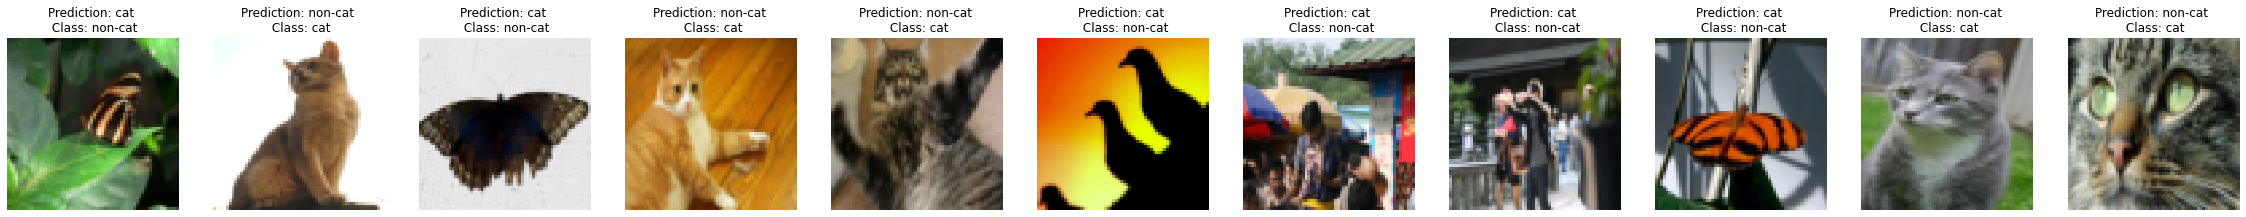

In [19]:
def print_mislabeled_images(classes, X, y, p):
    """
	绘制预测和实际不同的图像。
	    X - 数据集
	    y - 实际的标签
	    p - 预测
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))


print_mislabeled_images(classes, test_x, test_y, pred_test)